In [1]:
"""
"""
from __future__ import print_function
import os
import argparse
import pickle
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# tensorflow/keras imports 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

# qkeras and pruning imports 
from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

2024-06-10 11:16:21.224050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 11:16:21.460787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-10 11:16:21.460814: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-10 11:16:22.242332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Helper functions

In [2]:
def get_checkpoint_filename(checkpoint_dir, model_type, start, end, experiment_number, quantize, checkpoint_filename):
    if quantize == True:
        checkpoint_filename = f'q_{checkpoint_filename}'
    return os.path.join(checkpoint_dir, model_type, f'{start}_{end}', f'{experiment_number}', checkpoint_filename)

def get_callbacks(checkpoint_exp_filename, prune):
    callbacks = [
            ModelCheckpoint(
            checkpoint_exp_filename,
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            save_freq="epoch",
        ),
        ReduceLROnPlateau(patience=75, min_delta=1**-6),
    ]
    if prune:
        callbacks.append(pruning_callbacks.UpdatePruningStep())
    return callbacks

def load_checkpoint(filename):
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(filename, custom_objects=co, compile=False)
    return model

def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [3]:
def load_data(data_dir, window_start, window_end, bit_shift):
    print('#########################################################')
    print(f'Loading data from dir: {data_dir}')
    print('\tWindow start:', window_start)
    print('\tWindow end:', window_end)
    print('#########################################################')

    X_train_val = np.load(os.path.join(data_dir, 'X_train_0_770.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test_0_770.npy'))    
    y_train_val = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

    if window_start != 0 or window_end != 770:
        X_train_val = X_train_val[:,window_start*2:window_end*2]
        X_test = X_test[:,window_start*2:window_end*2]

    y_train_val = one_hot_encode(y_train_val)
    y_test = one_hot_encode(y_test)

    if bit_shift:
        shift = 3
        print(X_train_val.max())
        X_train_val = np.right_shift(X_train_val.astype(np.int32), shift)
        X_test = np.right_shift(X_test.astype(np.int32), shift)
        print(X_train_val.max())

    return X_train_val, X_test, y_train_val, y_test


#########################################################
# Model
#########################################################
def build_model(model_type, input_shape, quantize, is_pruning):
    model = Sequential()
    # build model 
    if model_type == 'mlp':
        sr = int(input_shape/2)
        hn = sr * 2
        if quantize:
            model.add(QDense(int(hn/8), input_shape=(sr*2,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
            model.add(QDense(2, name='fc2', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1)))
            model.add(Activation('relu'))
        else:
            model.add(Dense(int(hn/8), activation='relu', input_shape=(sr*2,)))
            model.add(BatchNormalization())
            model.add(Dense(2, activation='relu'))
    elif model_type == 'single':
        if quantize: 
            model.add(QDense(2, input_shape=(input_shape,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
            model.add(BatchNormalization())
        else:
            model.add(Dense(2, input_shape=(input_shape,), name='fc1'))
            model.add(BatchNormalization())
    # pruning options 
    if is_pruning == True:
        pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.85, begin_step=200, frequency=100)}
        # Define model for pruning
        pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
        model = prune.prune_low_magnitude(model, **pruning_params)
    return model 


In [4]:
#########################################################
# Training 
#########################################################
def train(model, X_train_val, y_train_val, lr, batch_size, epochs, val_split, callbacks):
    initial_learning_rate = lr
    opt = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    history = model.fit(X_train_val, 
              y_train_val, 
              batch_size=batch_size,
              epochs=epochs, 
              validation_split=val_split, 
              shuffle=True, 
              callbacks=callbacks
    )
    return history



In [5]:
def log_metrics(model, model_type, window_start, window_end, experiment_number, quantize, prune, train_acc, test_acc):
    # model parameters and sparsity 
    model_params_count = model.count_params()
    zero_params_count = 0
    for layer in model.layers:
        if len(layer.get_weights()) > 0:  # Some layers may not have weights
            params = layer.get_weights()
            for param in params:
                zero_params_count += np.sum(param == 0)

    print(f'Number of parameters: {model_params_count}')
    print(f'Number of zero parameters: {zero_params_count}')

    # save to file 
    with open('notebook_06102024.txt', 'a') as file:
        quantize = 1 if quantize == True else 0
        prune = 1 if prune == True else 0
        run_results = f'{model_type}_{window_start}_{window_end}, {experiment_number}, {quantize}, {prune}, {window_start}, {window_end}, {train_acc}, {test_acc}, {model_params_count}, {zero_params_count}\n'
        file.write(run_results)

def evaluate_model(model, checkpoint_exp_filename, history, prune, X_train, y_train, X_test, y_test):
    if prune == True:
        model = strip_pruning(model)

    print(f'Saved checkpoint to: {checkpoint_exp_filename}')
    history_file = checkpoint_exp_filename.replace(".h5", "-history.pkl")
    print(f'Saving history to: {history_file}')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # get test accuracy
    model = load_checkpoint(checkpoint_exp_filename)
    y_pred = model.predict(X_test)
    
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    print('Keras Test Accuracy: {}'.format(test_acc))

    # get train accuracy
    y_pred = model.predict(X_train)
    train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))
    print('Keras Train Accuracy: {}'.format(train_acc))

    return train_acc, test_acc
    

# Training parameters

In [6]:
# data options 
data_dir = '../data/malab_05272024/npz'
batch_size = 12800
window_start = 0
window_end = 770
bitshift_data = False
# training options 
max_epochs = 50
val_split = 0.1
lr = 1e-2
# model options 
model_types = ['single', 'mlp']
quantize = True
prune = True
# saving options 
checkpoint_dir = '../checkpoints'
checkpoint_filename = 'model_best.h5'

# space exploration
experiment_number = 0
num_experiments = 3
OFFSET = 100
INC_SIZE = 50
end_windwows = list(  # [150, 200, 250... 750]
    range(OFFSET + INC_SIZE, 770, INC_SIZE)
)
start_windows = [OFFSET] * len(end_windwows)  # [100, 100, 100... 100]
if end_windwows[-1] != 770:
    start_windows.append(0)
    end_windwows.append(770)


In [7]:
for model_type in model_types:
    for start, end in zip(start_windows, end_windwows):
        # load data 
        X_train, X_test, y_train, y_test = load_data(data_dir, start, end, bitshift_data)
        for exp_number in range(num_experiments):
            # build model 
            model = build_model(model_type, X_train.shape[1], quantize=False, is_pruning=False)
            model.build((batch_size, X_train.shape[1]))
            # train 
            checkpoint_exp_filename = get_checkpoint_filename(checkpoint_dir, model_type, start, end, exp_number, False, checkpoint_filename)
            callbacks = get_callbacks(checkpoint_exp_filename, prune)
            history = train(model, X_train, y_train, lr, batch_size, max_epochs, val_split, callbacks)
            # eval 
            train_acc, test_acc = evaluate_model(model, checkpoint_exp_filename, history, prune, X_train, y_train, X_test, y_test)
            log_metrics(model, model_type, start, end, exp_number, False, False, train_acc, test_acc)

        if quantize:
            for exp_number in range(num_experiments):
                # build model 
                model = build_model(model_type, X_train.shape[1], quantize=True, is_pruning=False)
                model.build((batch_size, X_train.shape[1]))
                # train 
                checkpoint_exp_filename = get_checkpoint_filename(checkpoint_dir, model_type, start, end, exp_number, True, checkpoint_filename)
                callbacks = get_callbacks(checkpoint_exp_filename, prune)
                history = train(model, X_train, y_train, lr, batch_size, max_epochs, val_split, callbacks)
                # eval 
                train_acc, test_acc = evaluate_model(model, checkpoint_exp_filename, history, prune, X_train, y_train, X_test, y_test)
                log_metrics(model, model_type, start, end, exp_number, True, False, train_acc, test_acc)



#########################################################
Loading data from dir: ../data/malab_05272024/npz
	Window start: 100
	Window end: 150
#########################################################


2024-06-10 11:16:57.055720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-10 11:16:57.055756: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-10 11:16:57.055787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-06-10 11:16:57.056084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 0.5879 - accuracy: 0.6961 - val_loss: 0.5883 - val_accuracy: 0.7200 - lr: 0.0100
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5562 - accuracy: 0.7218 - val_loss: 0.5615 - val_accuracy: 0.7205 - lr: 0.0100
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5557 - accuracy: 0.7225 - val_loss: 0.5578 - val_accuracy: 0.7209 - lr: 0.0100
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7223 - val_loss: 0.5572 - val_accuracy: 0.7206 - lr: 0.0100
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5555 - accuracy: 0.7226 - val_loss: 0.5569 - val_accuracy: 0.7207 - lr: 0.0100
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7224 - val_loss: 0.5568 - val_accuracy: 0.7209 - lr: 0.0100
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.5555 - a

# Visualize 

In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv('../dse-run2.txt', delimiter=',', names=['Model Type', 'Run', 'Quantized', 'Pruned', 'Window Start', 'Window End', 'Train Accuracy', 'Test Accuracy', 'Parameters', 'Zero Parameters'])
df = pd.read_csv('./notebook_dse.txt', delimiter=',', names=['Model Type', 'Run', 'Quantized', 'Pruned', 'Window Start', 'Window End', 'Train Accuracy', 'Test Accuracy', 'Parameters', 'Zero Parameters'])
df

,Model Type,Run,Quantized,Pruned,Window Start,Window End,Train Accuracy,Test Accuracy,Parameters,Zero Parameters
0,single_100_150,0,0,0,100,150,0.722523,0.72209,210,0
1,single_100_150,1,0,0,100,150,0.722361,0.72175,210,0
2,single_100_150,2,0,0,100,150,0.722572,0.72166,210,0
3,single_100_150,0,1,0,100,150,0.722302,0.72175,210,0
4,single_100_150,1,1,0,100,150,0.722672,0.72160,210,0
...,...,...,...,...,...,...,...,...,...,...
163,mlp_0_770,1,0,0,0,770,0.916683,0.91417,297026,0
164,mlp_0_770,2,0,0,0,770,0.917367,0.91374,297026,0
165,mlp_0_770,0,1,0,0,770,0.917261,0.91399,297026,0
166,mlp_0_770,1,1,0,0,770,0.917464,0.91408,297026,0


In [3]:
df[(df['Model Type'] == 'mlp_100_700') & (df['Quantized'] == 0)] 

,Model Type,Run,Quantized,Pruned,Window Start,Window End,Train Accuracy,Test Accuracy,Parameters,Zero Parameters
144,mlp_100_700,0,0,0,100,700,0.917233,0.91389,181052,0
145,mlp_100_700,1,0,0,100,700,0.916232,0.91410,181052,0
146,mlp_100_700,2,0,0,100,700,0.916174,0.91362,181052,0


In [4]:
single_acc = list()
single_std = list()
single_params = list()
single_window_size = list()
mlp_acc = list()
mlp_std = list()
mlp_params = list()
mlp_window_size = list()

for model_type in df['Model Type']:
    models = df[(df['Model Type'] == model_type) & (df['Quantized'] == 0)]    # models = df[(df['Model Type'] == model_type)]
    if models.empty == False:
        if 'single' in model_type:
            single_acc.append(models['Test Accuracy'].mean())
            single_std.append(models['Test Accuracy'].std())
            single_params.append(models['Parameters'].mean())
            single_window_size.append(int((models.iloc[0]['Window End'] - models.iloc[0]['Window Start'])))
        elif 'mlp' in model_type:
            mlp_acc.append(models['Test Accuracy'].mean())
            mlp_std.append(models['Test Accuracy'].std())
            mlp_params.append(models['Parameters'].mean())
            mlp_window_size.append(int((models.iloc[0]['Window End'] - models.iloc[0]['Window Start'])))
        else:
            raise Exception('Unknown model type', model_type)

single_acc_q = list()
single_std_q = list()
single_params_q = list()
mlp_acc_q = list()
mlp_std_q = list()
mlp_params_q = list()

for model_type in df['Model Type']:
    models = df[(df['Model Type'] == model_type) & (df['Quantized'] == 1)]    # models = df[(df['Model Type'] == model_type)]
    if models.empty == False:
        if 'single' in model_type:
            single_acc_q.append(models['Test Accuracy'].mean())
            single_std_q.append(models['Test Accuracy'].std())
            single_params_q.append(models['Parameters'].mean())
        elif 'mlp' in model_type:
            mlp_acc_q.append(models['Test Accuracy'].mean())
            mlp_std_q.append(models['Test Accuracy'].std())
            mlp_params_q.append(models['Parameters'].mean())
        else:
            raise Exception('Uknown model type', model_type)


In [5]:
single_acc = np.array(single_acc)*100
single_acc_q = np.array(single_acc_q)*100
mlp_acc = np.array(mlp_acc)*100
mlp_acc_q = np.array(mlp_acc_q)*100

In [6]:
plt.rcParams['font.family'] = 'serif'
size = 40
alpha = 1

71.46149999999999 241.5
80.64408 471.5
85.68813 701.5
88.25685000000001 931.5
90.38006999999999 3553.5
71.42949 1478.9
80.53419 5953.55
85.57593 13065.15
88.14498 23404.8
90.49359 341579.9


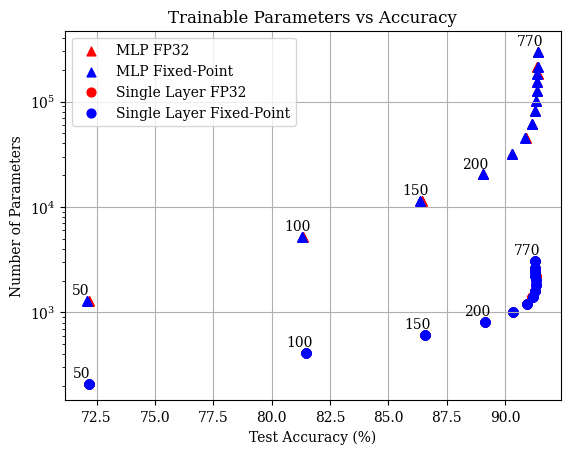

In [7]:
plt.figure()

plt.scatter(mlp_acc, mlp_params, marker='^', color='red', label='MLP FP32', s=size, alpha=alpha)
plt.scatter(mlp_acc_q, mlp_params_q, marker='^', color='blue', label='MLP Fixed-Point', s=size, alpha=alpha)
plt.scatter(single_acc, single_params, color='red', label='Single Layer FP32', s=size, alpha=alpha)
plt.scatter(single_acc_q, single_params_q, color='blue', label='Single Layer Fixed-Point', s=size, alpha=alpha)

acc_shift = 0.01
param_shift = 0.15
for idx in [0, 6, 12, 18, -1]:
    acc = single_acc[idx] - (single_acc[idx]*acc_shift)
    params = single_params[idx] + (single_params[idx]*param_shift)
    print(acc, params)
    plt.annotate(single_window_size[idx], (acc, params))

for idx in [0, 6, 12, 18, -1]:
    acc = mlp_acc[idx] - (mlp_acc[idx]*acc_shift)
    params = mlp_params[idx] + (mlp_params[idx]*param_shift)
    print(acc, params)
    plt.annotate(mlp_window_size[idx], (acc, params))


plt.grid()
plt.legend()
plt.yscale('log')
# increase ylim max so text doesn't get cut off 
ax = plt.gca()
y_limits = ax.get_ylim()
y_max = y_limits[1] + (y_limits[1]*0.1) 
ax.set_ylim((ax.get_ylim()[0], y_max))
# plt.tight_layout()
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Number of Parameters')
plt.title('Trainable Parameters vs Accuracy')
plt.savefig('../images/dse_params_vs_acc.pdf')

Text(0.5, 1.0, 'Trainable Parameters vs Accuracy')

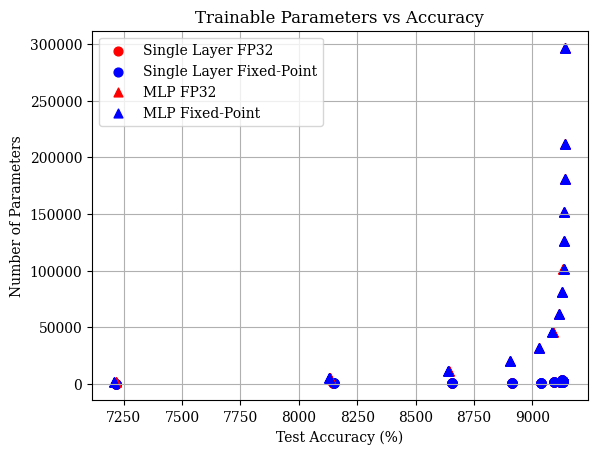

In [8]:
plt.figure()

plt.scatter(np.array(single_acc)*100, single_params, color='red', label='Single Layer FP32', s=size)
plt.scatter(np.array(single_acc_q)*100, single_params_q, color='blue', label='Single Layer Fixed-Point', s=size)

plt.scatter(np.array(mlp_acc)*100, mlp_params, marker='^', color='red', label='MLP FP32', s=size)
plt.scatter(np.array(mlp_acc_q)*100, mlp_params_q, marker='^', color='blue', label='MLP Fixed-Point', s=size)

plt.grid()
plt.legend()
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Number of Parameters')
plt.title('Trainable Parameters vs Accuracy')

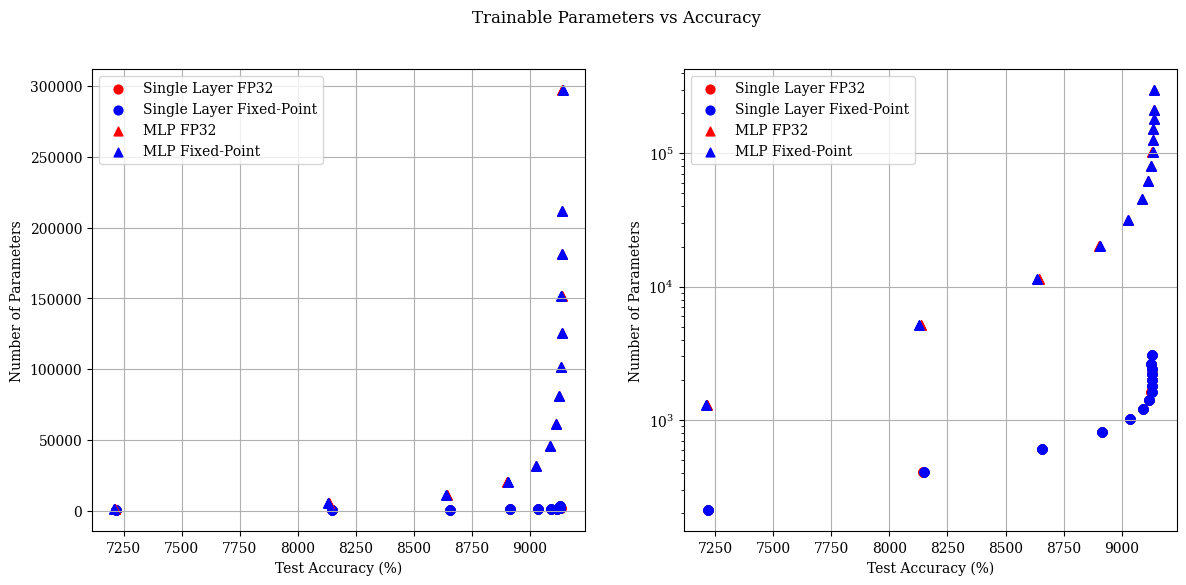

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(np.array(single_acc)*100, single_params, color='red', label='Single Layer FP32', s=size, alpha=alpha)
ax1.scatter(np.array(single_acc_q)*100, single_params_q, color='blue', label='Single Layer Fixed-Point', s=size, alpha=alpha)
ax1.scatter(np.array(mlp_acc)*100, mlp_params, marker='^', color='red', label='MLP FP32', s=size, alpha=alpha)
ax1.scatter(np.array(mlp_acc_q)*100, mlp_params_q, marker='^', color='blue', label='MLP Fixed-Point', s=size, alpha=alpha)
ax1.grid()
ax1.legend()
ax1.set_xlabel('Test Accuracy (%)')
ax1.set_ylabel('Number of Parameters')

ax2.scatter(np.array(single_acc)*100, single_params, color='red', label='Single Layer FP32', s=size, alpha=alpha)
ax2.scatter(np.array(single_acc_q)*100, single_params_q, color='blue', label='Single Layer Fixed-Point', s=size, alpha=alpha)
ax2.scatter(np.array(mlp_acc)*100, mlp_params, marker='^', color='red', label='MLP FP32', s=size, alpha=alpha)
ax2.scatter(np.array(mlp_acc_q)*100, mlp_params_q, marker='^', color='blue', label='MLP Fixed-Point', s=size, alpha=alpha)
ax2.grid()
ax2.legend()
ax2.set_yscale('log')
ax2.set_xlabel('Test Accuracy (%)')
ax2.set_ylabel('Number of Parameters')

fig.suptitle('Trainable Parameters vs Accuracy')
plt.savefig('../images/dse_params_vs_acc.pdf')